<a href="https://colab.research.google.com/github/Vandanakosuri/Pneumonia-Xray-detectionn/blob/Navaneeth/VNN_%26_Dense3Net_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Activation, Input, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D,BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from keras.optimizers import Adam
import tensorflow as tf


import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: viswabhavitha
Your Kaggle Key: ··········


100%|██████████| 1.14G/1.14G [00:41<00:00, 29.5MB/s]


In [5]:
train_path = "../content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train"
test_path = "../content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test"

In [6]:
normal_images = [img for img in os.listdir(f'{train_path}/NORMAL')]
pneumonia_images = [img for img in os.listdir(f'{train_path}/PNEUMONIA')]

In [7]:
normal_select = np.random.choice(normal_images, 5, replace=False)
pneumonia_select = np.random.choice(pneumonia_images, 5, replace=False)

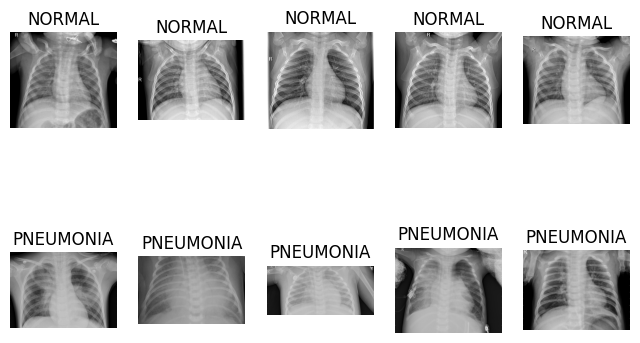

In [8]:
#Plot the selected images
from tensorflow.keras.preprocessing import image
fig = plt.figure(figsize=(8,5))
for i in range(10):
    if i<5:
        fpath = f'{train_path}/NORMAL/{normal_select[i]}'
        label = 'NORMAL'
    else:
        fpath = f'{train_path}/PNEUMONIA/{pneumonia_select[i-5]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2,5,i+1)

    im = image.load_img(fpath)
    plt.imshow(im)
    plt.title(label)
    plt.axis('off')
plt.show()

In [9]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [10]:
batch_size = 8
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(180,180),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(180,180),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(180,180),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
vgg_model = Sequential()

vgg_pretrained_model=VGG16(include_top=False,input_shape=(180,180,3),pooling='avg',classes=2,weights='imagenet')

for layer in vgg_pretrained_model.layers:
        layer.trainable=False

vgg_model.add(vgg_pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(2, activation='sigmoid'))

58889256/58889256 [==============================] - 3s 0us/step


In [12]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14978370 (57.14 MB)
Trainable params: 263682 (1.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
vgg_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=["accuracy","AUC","Precision","Recall"])

vgg_model_history = vgg_model.fit(train_generator, validation_data=train_generator, epochs=3)

Epoch 1/3
 12/524 [..............................] - ETA: 25:44 - loss: 0.6204 - accuracy: 0.7292 - auc: 0.7844 - precision: 0.7188 - recall: 0.7188

In [ ]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(vgg_model_history.history['accuracy'])
plt.plot(vgg_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(vgg_model_history.history['loss'])
plt.plot(vgg_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

In [ ]:
test_generator.reset()

pred = vgg_model.predict(test_generator, steps = len(test_generator), verbose = 2)

predicted_class_indices = np.argmax(pred, axis = 1)

In [ ]:
def Targetization(folder_path, target_path):
    label = []
    for path, tag in target_path:
        for filename in os.listdir(folder_path + path):
            img = cv2.imread(os.path.join(folder_path, path, filename)) # second param: 0 is b&w picture
            if img is not None:
                label.append(tag)
    return np.array(label)



In [ ]:
base_dir= "../content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/"
y_test = Targetization(base_dir, target_path=[("test/NORMAL/", 0,), ("test/PNEUMONIA/", 1,)])

In [ ]:
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(classification_report(y_test, predicted_class_indices))
plt.show()

**DenseNet121 Implementation**

In [ ]:
denset_net_pretrained_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(180, 180, 3)))
# construct the head of the model that will be placed on top of the
# the base model
dense_net_model = Sequential()
dense_net_model.add(denset_net_pretrained_model)
dense_net_model.add(GlobalAveragePooling2D())
dense_net_model.add(Flatten())
dense_net_model.add(Dropout(0.5))
dense_net_model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
dense_net_model.add(Dropout(0.5))
dense_net_model.add(Dense(2, activation='sigmoid'))
for layer in denset_net_pretrained_model.layers[:]:
    layer.trainable = False

In [ ]:
dense_net_model.summary()

In [ ]:
dense_net_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=["accuracy","AUC","Precision","Recall"])

history_dense_net_model = dense_net_model.fit(train_generator, validation_data=train_generator, epochs=3)

In [ ]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(history_dense_net_model.history['accuracy'])
plt.plot(history_dense_net_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(history_dense_net_model.history['loss'])
plt.plot(history_dense_net_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

In [ ]:
test_generator.reset()

pred = dense_net_model.predict(test_generator, steps = len(test_generator), verbose = 2)

predicted_class_indices = np.argmax(pred, axis = 1)

In [ ]:
base_dir= "../content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/"
y_test = Targetization(base_dir, target_path=[("test/NORMAL/", 0,), ("test/PNEUMONIA/", 1,)])

In [ ]:
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(classification_report(y_test, predicted_class_indices))
plt.show()